In [1]:
from finn_examples.driver import FINNExampleOverlay
from qonnx.core.datatype import DataType
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/pl_server/xrt_device.py:59: UserWarning: xbutil failed to run - unable to determine XRT version
  warnings.warn("xbutil failed to run - unable to determine XRT version")


In [2]:
_cifar10_lfc_io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : [DataType['UINT8']],
    "odt" : [DataType['UINT8']],
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : [(1, 784)],
    "oshape_normal" : [(1, 1)],
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : [(1, 784, 1)],
    "oshape_folded" : [(1, 1, 1)],
    "ishape_packed" : [(1, 784, 1)],
    "oshape_packed" : [(1, 1, 1)],
    "input_dma_name" : ['idma0'],
    "output_dma_name" : ['odma0'],
    "number_of_external_weights": 0,
    "num_inputs" : 1,
    "num_outputs" : 1,
}

In [3]:
# filename= "cnn_1w1a.bit"
filename="./models/lfc_1w1a.bit"
driver_mode= "zynq-iodma"
accel= FINNExampleOverlay(filename, driver_mode, _cifar10_lfc_io_shape_dict)

In [4]:
from dataset_loading import mnist
trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data("/home/root/jupyter_notebooks/case2024/datasets", download=True, one_hot=False)

Looking for Train Imgs
Tar File found in data_dir. Not Downloading again
Looking for Train Labels
Tar File found in data_dir. Not Downloading again
Looking for Test Imgs
Tar File found in data_dir. Not Downloading again
Looking for Test Labels
Tar File found in data_dir. Not Downloading again


In [5]:
testx.shape

(10000, 28, 28, 1)

In [6]:
test_single_x = testx[0].reshape(28, 28)
test_single_y = testy[0]

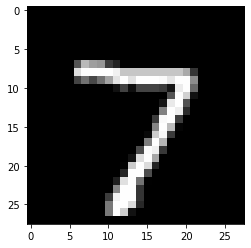

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt



plt.imshow(test_single_x, cmap='gray')
plt.show()

In [8]:
print("Expected class is %d" % test_single_y)

Expected class is 7


In [9]:
accel_in = test_single_x.reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 784) and datatype is uint8


In [10]:
accel_out = accel.execute(accel_in)

In [11]:
accel_out

PynqBuffer([[7.]], dtype=float32)

In [12]:
print("Returned class is %d" % accel_out)

Returned class is 7


In [13]:
classes = ['zero', 'one' , 'two',
    'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine']

clases_np= np.array(classes)

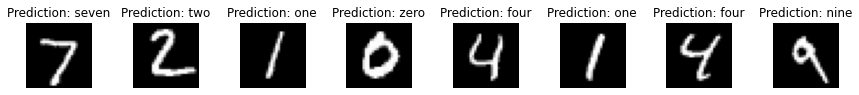

In [14]:
num_pics  = 8
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    
    accel_in = testx[i].reshape(accel.ishape_normal())
    accel_out = accel.execute(accel_in)
    
    prediction = accel_out

    ax[i].set_title('Prediction: ' + classes[int(prediction)])
    ax[i].axis('off')
    ax[i].imshow(testx[i], cmap='gray')

In [15]:
accel.throughput_test()

{'runtime[ms]': 0.4916191101074219,
 'throughput[images/s]': 2034.0950533462658,
 'DRAM_in_bandwidth[MB/s]': 1.5947305218234724,
 'DRAM_out_bandwidth[MB/s]': 0.002034095053346266,
 'fclk[mhz]': 99.999,
 'batch_size': 1,
 'fold_input[ms]': 0.034809112548828125,
 'pack_input[ms]': 0.03457069396972656,
 'copy_input_data_to_device[ms]': 0.20742416381835938,
 'copy_output_data_from_device[ms]': 0.09322166442871094,
 'unpack_output[ms]': 0.31065940856933594,
 'unfold_output[ms]': 0.05698204040527344}

In [16]:
from time import time

correct= 0
total= len(testx)
start = time()

for i in range(total):
    
    accel_in = testx[i].reshape(accel.ishape_normal())
    accel_out = accel.execute(accel_in)
    
    prediction = int(accel_out[0])
    if prediction==testy[i]:
        correct+=1

stop = time()
#correct = np.sum(clases_np[predictions]==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))  

Overall accuracy: 0.9868
  Execution time: 9.7321s
      Throughput: 1027.5240FPS


In [17]:
import numpy as np

batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))

Ready to run validation, test images tensor has shape (10, 1000, 784)
Accelerator buffer shapes are (1000, 784, 1) for input, (1000, 1, 1) for output


In [18]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
    exp = batch_labels[i]
    obuf_normal = accel.execute(ibuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 987 NOK 13
batch 1 / 10 : total OK 1959 NOK 41
batch 2 / 10 : total OK 2940 NOK 60
batch 3 / 10 : total OK 3924 NOK 76
batch 4 / 10 : total OK 4907 NOK 93
batch 5 / 10 : total OK 5897 NOK 103
batch 6 / 10 : total OK 6888 NOK 112
batch 7 / 10 : total OK 7886 NOK 114
batch 8 / 10 : total OK 8882 NOK 118
batch 9 / 10 : total OK 9868 NOK 132


In [19]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 98.68%


In [20]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
        exp = batch_labels[i]
        accel.execute(ibuf_normal)

In [21]:
full_validation_time = %timeit -n 1 -o run_validation()

863 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

11589.661350 images per second including data movement


In [24]:
run_validation()

In [25]:
del accel